## Task

The task is to create a language model that can effectively classify diseases based on a short description of its symptoms.


The dataset contains 50 descriptions for each disease, which turns out too less to train a model from scratch. Hence, I tried using a pretrained 
transformer model for this. Thanks to 🤗.


## Importing Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import os
from tqdm.notebook import tqdm
import re
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer

plt.style.use('ggplot')
np.__version__

'1.21.6'

In [2]:
!pip install transformers

## Loading the data

In [3]:
df = pd.read_csv('/kaggle/input/symptom2disease/Symptom2Disease.csv')
df.head()

,Unnamed: 0,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"My nails have small dents or pits in them, and..."


In [ ]:
df.info()

Creating encodings for disease.

In [4]:
int2label = {}

for i, disease in enumerate(df['label'].unique()):
    int2label[i] = disease

label2int = {v : k for k, v in int2label.items()}
num_classes = len(int2label)

int2label, label2int

({0: 'Psoriasis',
  1: 'Varicose Veins',
  2: 'Typhoid',
  3: 'Chicken pox',
  4: 'Impetigo',
  5: 'Dengue',
  6: 'Fungal infection',
  7: 'Common Cold',
  8: 'Pneumonia',
  9: 'Dimorphic Hemorrhoids',
  10: 'Arthritis',
  11: 'Acne',
  12: 'Bronchial Asthma',
  13: 'Hypertension',
  14: 'Migraine',
  15: 'Cervical spondylosis',
  16: 'Jaundice',
  17: 'Malaria',
  18: 'urinary tract infection',
  19: 'allergy',
  20: 'gastroesophageal reflux disease',
  21: 'drug reaction',
  22: 'peptic ulcer disease',
  23: 'diabetes'},
 {'Psoriasis': 0,
  'Varicose Veins': 1,
  'Typhoid': 2,
  'Chicken pox': 3,
  'Impetigo': 4,
  'Dengue': 5,
  'Fungal infection': 6,
  'Common Cold': 7,
  'Pneumonia': 8,
  'Dimorphic Hemorrhoids': 9,
  'Arthritis': 10,
  'Acne': 11,
  'Bronchial Asthma': 12,
  'Hypertension': 13,
  'Migraine': 14,
  'Cervical spondylosis': 15,
  'Jaundice': 16,
  'Malaria': 17,
  'urinary tract infection': 18,
  'allergy': 19,
  'gastroesophageal reflux disease': 20,
  'drug reacti

## Data Distribution

The dataset contains 24 diseases and each disease has 50 descriptions of the respective symptoms.

Text(0.5, 1.0, 'Count of each disease')

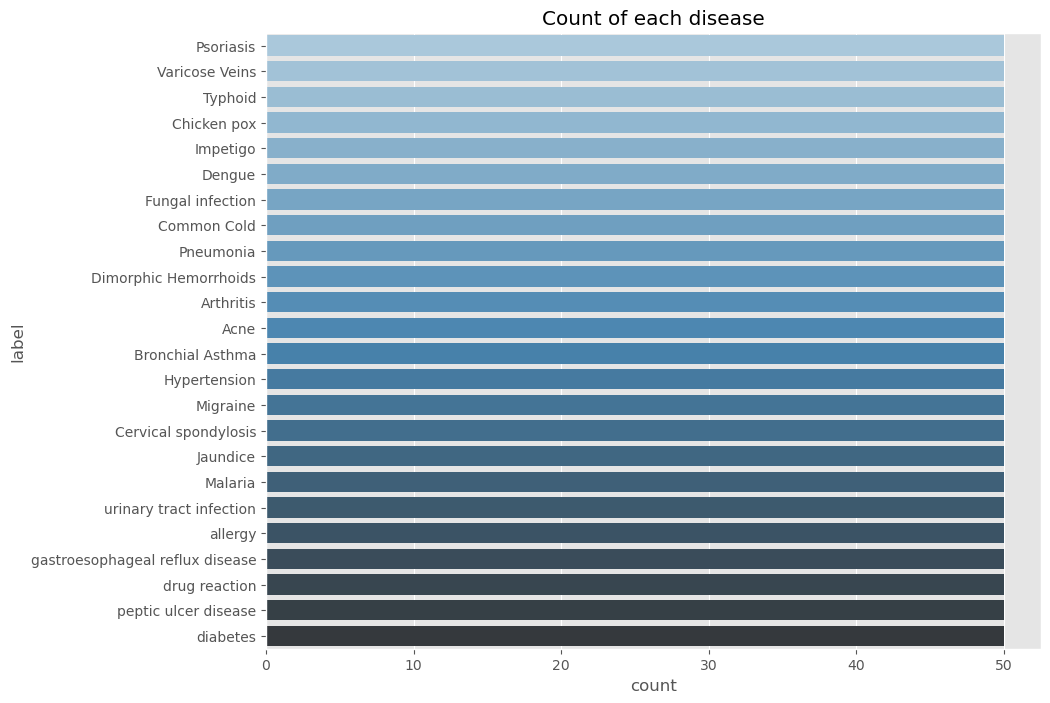

In [6]:
plt.figure(figsize = (10, 8))

sea.countplot(y = df['label'], palette = 'Blues_d')
plt.title('Count of each disease')

## Distribution of the lenght of description

  0%|          | 0/1200 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Distribution of description length')

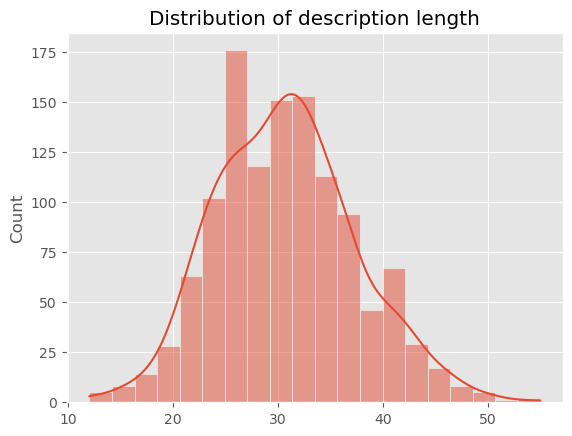

In [7]:
length = []
for txt in tqdm(df['text'].values):
    length.append(len(txt.split()))

sea.histplot(length, kde = True, bins = 20)
plt.title('Distribution of description length')

## Lets clean data

In [5]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

In [6]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
#set of English stop words
stop_words = set(stopwords.words('english'))

In [8]:
def clean_text(sent):
    #remove punctuations
    sent = sent.translate(str.maketrans('','',string.punctuation)).strip()
    
    #remove stopwords
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(sent)
    words = [word for word in words if word not in stop_words]
    
    return " ".join(words).lower()

In [9]:
# apply clean_text on text column of df
df["text"] = df["text"].apply(clean_text)

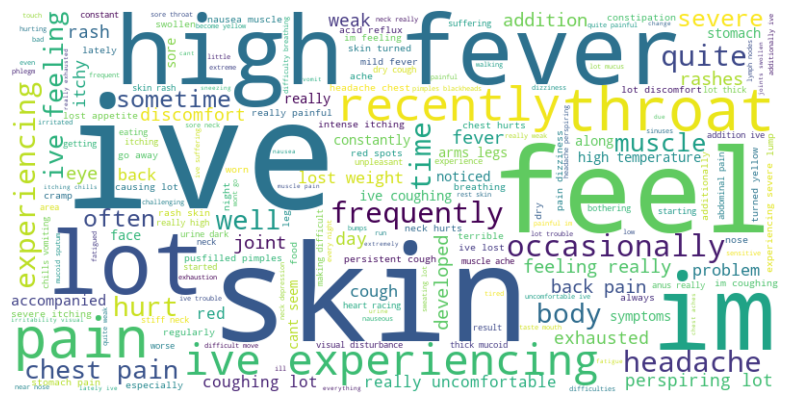

In [10]:
# create word cloud to vizualize frequent words in our dataset
all_text = " ".join(df["text"])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)


# Plotting Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Tokanize Data

In [11]:
df['label'] = df['label'].map(lambda x : label2int[x])

In [12]:
X, y = df['text'].values, df['label'].values

x_tokenizer = Tokenizer(filters = '')
x_tokenizer.fit_on_texts(X)
x_vocab = len(x_tokenizer.word_index) + 1
print("X vocab:", x_vocab)

X vocab: 1511


## Creating the train and testing data

90% of the dataset is used for training and remaining 10% for validation and testing.

In [13]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.1, stratify = y)
train_x.shape, val_x.shape, train_y.shape, val_y.shape


((1080,), (120,), (1080,), (120,))

## Converting the data into `tf.data.Dataset`

1. The tokenizer of pretrained bert is downloaded and used.
2. `train_dataset` and `val_dataset` is created using `tf.data.Dataset` with batch size 8.

In [14]:
from transformers import AutoTokenizer
BATCH_SIZE = 8

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
train_encodings = tokenizer(list(train_x), padding="max_length", truncation=True)
val_encodings = tokenizer(list(val_x), padding="max_length", truncation=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_y
)).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_y
)).batch(BATCH_SIZE)


In [15]:
pip install keras --upgrade

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


## Loading the Pretrained BERT Model

1. We pass the label encodings to the model. 
2. We use SparseCategoricalCrossentropy for the loss function.
3. Adam for the optimizer with a small learning rate of 0.00003


In [16]:
num_classes = 24

from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased", 
    num_labels = num_classes, 
    id2label = int2label, 
    label2id = label2int,
    output_attentions = True)

model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = keras.optimizers.Adam(learning_rate = 3e-5),
    metrics = ['accuracy'])

model

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  18456     
                                                                 
Total params: 108,328,728
Trainable params: 108,328,728
Non-trainable params: 0
_________________________________________________________________


In [18]:
for layer in model.layers:
    print(layer, layer.trainable)

<transformers.models.bert.modeling_tf_bert.TFBertMainLayer object at 0x7cbba426afd0> True
<keras.layers.regularization.dropout.Dropout object at 0x7cbac9687f50> True
<keras.layers.core.dense.Dense object at 0x7cbac962e910> True


## Fine tuning the model

1. The model is fined tuned for 3 epochs.

In [19]:
EPOCHS = 3

history = model.fit(train_dataset, 
          epochs = EPOCHS, 
          validation_data = val_dataset)

Epoch 1/3
135/135 [==============================] - 134s 609ms/step - loss: 2.7526 - accuracy: 0.3019 - val_loss: 1.8897 - val_accuracy: 0.6583
Epoch 2/3
135/135 [==============================] - 79s 584ms/step - loss: 1.3244 - accuracy: 0.8074 - val_loss: 0.8126 - val_accuracy: 0.9167
Epoch 3/3
135/135 [==============================] - 79s 584ms/step - loss: 0.5021 - accuracy: 0.9583 - val_loss: 0.3221 - val_accuracy: 0.9750


## Plotting the loss and accuracy plot.

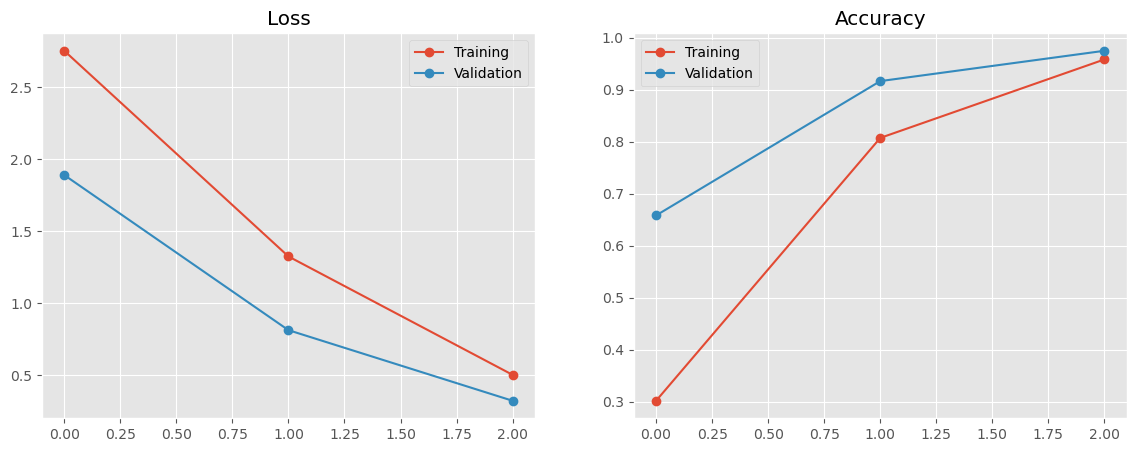

In [20]:
plt.figure(figsize = (14, 5))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], marker = 'o', label = 'Training')
plt.plot(history.history['val_loss'], marker='o', label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], marker = 'o', label = 'Training')
plt.plot(history.history['val_accuracy'], marker='o', label = 'Validation')
plt.legend()


## Testing the model on custom input.

In [21]:
from transformers import TextClassificationPipeline

# Initialize the pipeline
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=num_classes)

# Make predictions
pred1 = pipe("I am experiencing rashes on my skin. It is itchy and is now swelling. Even my skin is starting to peel.")
pred2 = pipe("I have constipation and belly pain, and it's been really uncomfortable. The belly pain has been getting worse and is starting to affect my daily life. Moreover, I get chills every night, followed by a mild fever.")

# print(pred1[0][0]['label'])

# # Print the highest label for each prediction
print("pred1:", pred1[0][0]['label'])
print("pred2:", pred2[0][0]['label'])


pred1: Psoriasis
pred2: Typhoid


## Saving the model

In [22]:
# Save the model
model.save_pretrained('/kaggle/working/bert_model')
tokenizer.save_pretrained('/kaggle/working/bert_tokenizer')


('/kaggle/working/bert_tokenizer/tokenizer_config.json',
 '/kaggle/working/bert_tokenizer/special_tokens_map.json',
 '/kaggle/working/bert_tokenizer/vocab.txt',
 '/kaggle/working/bert_tokenizer/added_tokens.json',
 '/kaggle/working/bert_tokenizer/tokenizer.json')

### The model was made in a kaggle notebook and the saved model was download on the local machine in bert_model folder